In [116]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib 
matplotlib.rcParams['figure.figsize'] = (10, 6)

%matplotlib inline
import numpy as np
import pandas as pd

Number of failed rows: 12
Original number of runs: 432
New number of runs 420
FILTER NO CHANGE False
======== Main Results ========
Difference between baseline and trivial_deadcode_elimination
	Mean 1.00606 x
	stddev 0.01760
	Median 1.00000 x
Difference between baseline and constant_folding
	Mean 1.00779 x
	stddev 0.01888
	Median 1.00002 x
Difference between baseline and liveness
	Mean 1.00636 x
	stddev 0.01768
	Median 1.00000 x
Difference between baseline and constant_liveness
	Mean 1.00800 x
	stddev 0.01886
	Median 1.00025 x


/var/folders/9b/50w4n7dj6wg7y4zw63b_fz5r0000gp/T/ipykernel_51588/455279262.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['result'] = df['result'].astype(int)


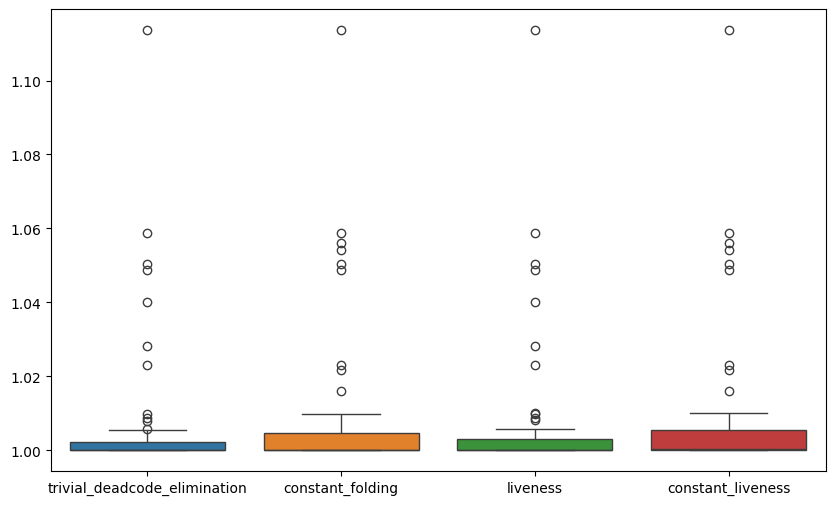

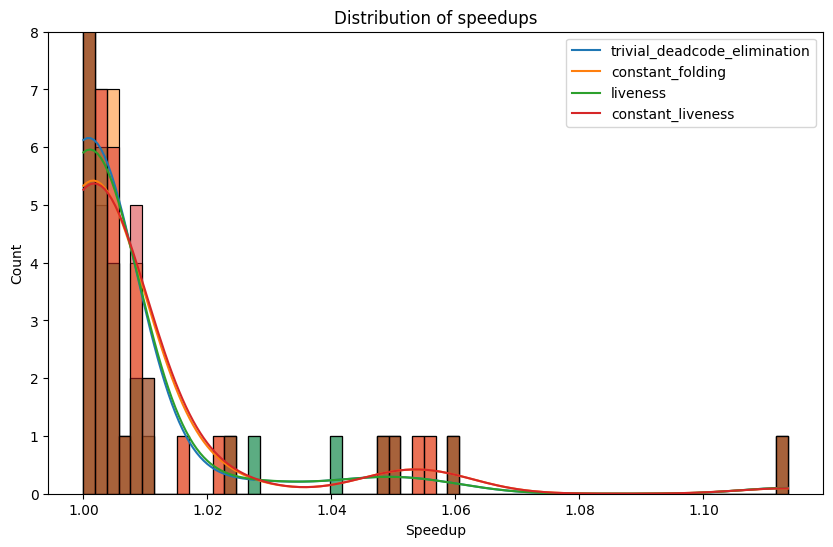

======== Perf to trivial DCE ========
Difference between constant_folding and constant_liveness
	Mean 1.00021 x
	stddev 0.00127
	Median 1.00000 x


array([1.        , 1.0035087 , 1.        , 1.        , 1.01016949,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.00059242, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.00028952, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

In [145]:
def clean_csv(df):
    num_runs_failed = len(df[(df.result == 'incorrect') | (df.result == 'timeout')])
    num_runs = len(df)
    print('Number of failed rows:', num_runs_failed)
    print('Original number of runs:', num_runs)
    df = df[(df.result != 'incorrect') & (df.result != 'timeout')]
    print('New number of runs', len(df))
    df['result'] = df['result'].astype(int)
    return df

def print_array_stats(result):
    print('\tMean', f'{result.mean():.5f}', 'x')
    print('\tstddev', f'{result.std():.5f}')
    print('\tMedian', f'{np.median(result):.5f}', 'x')
    # print('\tMin', result.min())
    # print('\tMax', result.max())

def run_stats(df):
    for run_name in df.run.unique():
        print(run_name, 'Stats')
        _df = df[df.run == run_name]
        result = _df.result.to_numpy(dtype=int)
        print_array_stats(result)
    # return df.boxplot(column='result', by='run')
    return sns.boxplot(df, x='result', y='run')

def improvement(df, baseline, run, filter_no_change=False):
    suffixes=('_'+baseline, '_' + run)
    print('Difference between', baseline, 'and', run )
    baseline = df[df.run == baseline]
    run = df[df.run == run]
    merged = baseline.merge(run, on='benchmark', suffixes=suffixes)
    baseline_key = 'result' + suffixes[0]
    run_key = 'result' + suffixes[1]
    speedup = merged[baseline_key] / merged[run_key]
    speedup = speedup.to_numpy()
    if filter_no_change:
        speedup = speedup[speedup != 1]
    print_array_stats(speedup)
    return speedup

df = pd.read_csv('results.csv')
df = clean_csv(df)

def header(x):
    print('=========== Improvement of', x, '===========')
filter_no_change = False
print('FILTER NO CHANGE', filter_no_change)
print('======== Main Results ========')
baseline = 'baseline'
runs = ['trivial_deadcode_elimination', 'constant_folding', 'liveness', 'constant_liveness']
boxplot_data = {}
for r in runs:
    speedup = improvement(df, baseline, r, filter_no_change = filter_no_change)
    boxplot_data[r] = speedup 
sns.boxplot(boxplot_data)
plt.show()
labels = []
bins = 60
for r, v in boxplot_data.items():
    labels.append(r)
    sns.histplot(v, kde=True, legend=r,  multiple='layer', bins=bins)
    # sns.displot(v, rug=True, kde=True)
    # plt.title(r)
    # plt.show()
plt.legend(labels)
plt.title('Distribution of speedups')
plt.ylim(0, 8)
plt.xlabel('Speedup')
plt.show()

print('======== Perf to trivial DCE ========')
improvement(df, 'constant_folding', 'constant_liveness', filter_no_change=filter_no_change)

In [90]:
df

,benchmark,run,result
0,quadratic,baseline,785
1,quadratic,trivial_deadcode_elimination,783
2,quadratic,constant_folding,829
3,quadratic,liveness,783
4,primes-between,baseline,574100
...,...,...,...
282,eight-queens,constant_folding,977479
283,eight-queens,liveness,959702
284,binary-search,baseline,78
285,binary-search,trivial_deadcode_elimination,75


In [38]:
# df['result'] = df['result'].replace('incorrect', np.inf)
# len(df[df.result == 'incorrect' or df.result == 'timeout'])
(df.result == 'incorrect') | (df.result == 'timeout')

0      False
1      False
2      False
3      False
4      False
       ...  
283    False
284    False
285    False
286    False
287    False
Name: result, Length: 288, dtype: bool

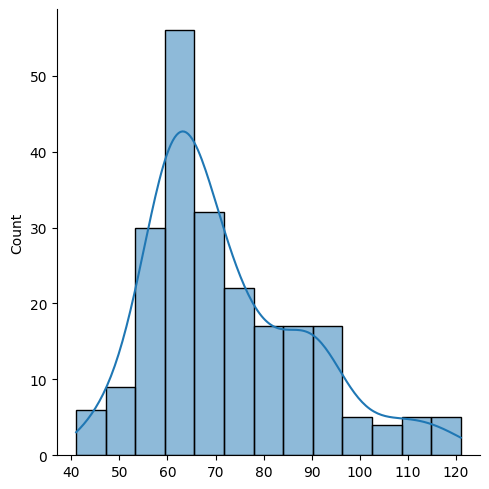

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

l = [41, 44, 46, 46, 47, 47, 48, 48, 49, 51, 52, 53, 53, 53, 53, 55, 55, 55,
     55, 56, 56, 56, 56, 56, 56, 57, 57, 57, 57, 57, 57, 57, 57, 58, 58, 58,
     58, 59, 59, 59, 59, 59, 59, 59, 59, 60, 60, 60, 60, 60, 60, 60, 60, 61,
     61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 62, 62, 62, 62, 62, 62, 62, 62,
     62, 63, 63, 63, 63, 63, 63, 63, 63, 63, 64, 64, 64, 64, 64, 64, 64, 65,
     65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 66, 66, 66, 66, 66, 66, 66,
     67, 67, 67, 67, 67, 67, 67, 67, 68, 68, 68, 68, 68, 69, 69, 69, 70, 70,
     70, 70, 71, 71, 71, 71, 71, 72, 72, 72, 72, 73, 73, 73, 73, 73, 73, 73,
     74, 74, 74, 74, 74, 75, 75, 75, 76, 77, 77, 78, 78, 79, 79, 79, 79, 80,
     80, 80, 80, 81, 81, 81, 81, 83, 84, 84, 85, 86, 86, 86, 86, 87, 87, 87,
     87, 87, 88, 90, 90, 90, 90, 90, 90, 91, 91, 91, 91, 91, 91, 91, 91, 92,
     92, 93, 93, 93, 94, 95, 95, 96, 98, 98, 99, 100, 102, 104, 105, 107, 108,
     109, 110, 110, 113, 113, 115, 116, 118, 119, 121]

sns.displot(l, kde=True, rug=False)

plt.show()
